Code written based on results provided in "Approximating the pth root by composite rational functions" by Yuji Nakatsukasa

In [9]:
# -----------------------------
# ICML-ready plotting utilities
# -----------------------------
import os
import numpy as np
import matplotlib.pyplot as plt

_ICML_STYLE_APPLIED = False

def set_icml_style():
    # Minimal, paper-friendly style (serif + STIX math; light grid; no heavy spines).
    global _ICML_STYLE_APPLIED
    if _ICML_STYLE_APPLIED:
        return
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "Nimbus Roman", "DejaVu Serif"],
        "mathtext.fontset": "stix",
        "font.size": 8.5,
        "axes.labelsize": 8.5,
        "axes.titlesize": 8.5,
        "legend.fontsize": 7.5,
        "xtick.labelsize": 7.5,
        "ytick.labelsize": 7.5,
        "axes.linewidth": 0.8,
        "lines.linewidth": 1.6,
        "lines.markersize": 4.0,
        "lines.solid_capstyle": "round",
        "savefig.dpi": 300,
        "figure.dpi": 150,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.015,
    })
    _ICML_STYLE_APPLIED = True

def _format_ax(ax):
    # clean look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(direction="out", length=3.0, width=0.8)
    ax.grid(True, which="major", alpha=0.22, linewidth=0.6)
    ax.grid(True, which="minor", alpha=0.12, linewidth=0.5)
    ax.minorticks_on()

def icml_fig(width="double", height=3.1):
    set_icml_style()
    w = 3.25 if width == "single" else 6.75
    fig = plt.figure(figsize=(w, height), constrained_layout=True)
    return fig

def icml_save(fig, filename_base, out_dir="fig_icml"):
    os.makedirs(out_dir, exist_ok=True)
    pdf_path = os.path.join(out_dir, filename_base + ".pdf")
    png_path = os.path.join(out_dir, filename_base + ".png")
    fig.savefig(pdf_path)
    fig.savefig(png_path)
    return pdf_path, png_path

def safe_log10(vals, floor=-60.0):
    # Convert positive mp/float values to log10, but stop drawing once we hit the numerical floor.
    out = []
    hit_floor = False
    for v in vals:
        if hit_floor:
            out.append(np.nan)
            continue
        vf = float(v)
        if vf <= 0:
            out.append(np.nan)
            continue
        lv = np.log10(vf)
        if lv < floor:
            out.append(np.nan)
            hit_floor = True
        else:
            out.append(lv)
    return np.array(out, dtype=float)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp

# ---------- building blocks in high precision ----------

def mu_mp(alpha, p):
    """High-precision µ(α) with safeguard near α = 1."""
    one = mp.mpf('1')
    # tolerance based on current precision
    tol = mp.mpf(10) ** (-(mp.mp.dps - 10))
    if abs(one - alpha) < tol:
        # limit as α -> 1 is µ(1) = 1
        return one
    return ((alpha - alpha**p) / ((p - 1) * (one - alpha))) ** (one / p)

def alpha_next_mp(alpha, p):
    """α_{k+1} from eq. (14)."""
    m = mu_mp(alpha, p)
    return (p * alpha) / ((p - 1) * m + m**(1 - p) * alpha**p)

def r_step_mp(x_vals, f_vals, alpha_k, p):
    """
    One compositional step (13):
        f_{k+1}(x) =
            ((p-1)*µ(α_k)*f_k(x) + x / (µ(α_k)^(p-1) * f_k(x)^(p-1))) / p
    x_vals, f_vals are lists of mp.mpf.
    """
    m = mu_mp(alpha_k, p)
    new_f = []
    for x, y in zip(x_vals, f_vals):
        num = (p - 1) * m * y + x / (m**(p - 1) * y**(p - 1))
        new_f.append(num / p)
    return new_f

def composite_errors_full_mp(p=2, alpha0=0.5, K=6, dps=80, N=401):
    """
    FULL verification:
      - Build grid x in [alpha0^p, 1]
      - Iterate f_k(x) via the composite recurrence
      - At each k, compute:
          * theoretical δ_k = (1-α_k)/(1+α_k)
          * numerical max relative error over the grid

    Returns:
      ks            : list of iteration indices
      delta_theory  : list of mp.mpf (theoretical δ_k)
      delta_num     : list of mp.mpf (numerical max relative error)
    """
    mp.mp.dps = dps
    alpha = mp.mpf(alpha0)
    one = mp.mpf('1')
    p_mp = mp.mpf(p)

    # grid on [α^p, 1] in high precision
    x_min = alpha ** p_mp
    xs = [x_min + (one - x_min) * mp.mpf(i) / (N - 1) for i in range(N)]
    roots = [x ** (one / p_mp) for x in xs]

    # initial f_0(x) = 1
    f_vals = [one for _ in xs]

    ks = []
    delta_theory = []
    delta_num = []

    for k in range(K + 1):
        # scaled approximant ˜f_k(x)
        scale = 2 * alpha / (one + alpha)
        approx = [scale * y for y in f_vals]

        # true max relative error on the grid
        rel_errs = [abs(a - r) / r for a, r in zip(approx, roots)]
        max_rel = max(rel_errs)

        # theoretical δ_k
        delta_k = (one - alpha) / (one + alpha)

        ks.append(k)
        delta_theory.append(delta_k)
        delta_num.append(max_rel)

        if k < K:
            f_vals = r_step_mp(xs, f_vals, alpha, p_mp)
            alpha = alpha_next_mp(alpha, p_mp)

    return ks, delta_theory, delta_num

# ---------- example run ----------

if __name__ == "__main__":
    p = 10
    alpha0 = 0.5
    K = 10
    dps = 300   # high precision
    N = 201    # grid points for [α^p,1]

    ks, delta_th, delta_num = composite_errors_full_mp(
        p=p, alpha0=alpha0, K=K, dps=dps, N=N
    )

    print("k | theoretical_delta              numerical_max_rel_err          difference")
    for k, dt, dn in zip(ks, delta_th, delta_num):
        dt_f = float(dt)
        dn_f = float(dn)
        print(f"{k:1d} | {dt_f:24.16e}  {dn_f:24.16e}  {abs(dt_f-dn_f):.2e}")



# -----------------------------
# Demo data for Step 1 (pth-root)
# -----------------------------
PLOT_INDIVIDUAL = False

p = 10
alpha0 = 0.5
K = 10
dps = 300   # keep your precision
N = 201     # grid points

ks, delta_th, delta_num = composite_errors_full_mp(p=p, alpha0=alpha0, K=K, dps=dps, N=N)

pthroot_demo = {
    'p': p, 'alpha0': alpha0, 'K': K, 'dps': dps, 'N': N,
    'ks': np.array(ks, dtype=int),
    'delta_th': delta_th,
    'delta_num': delta_num,
}

k | theoretical_delta              numerical_max_rel_err          difference
0 |   3.3333333333333331e-01    3.3333333333333331e-01  0.00e+00
1 |   1.8236054170684812e-01    1.8236054170684812e-01  0.00e+00
2 |   6.6062293850759929e-02    6.6062293850759929e-02  0.00e+00
3 |   9.6373861988933648e-03    9.6373861988933648e-03  0.00e+00
4 |   2.0889310092188446e-04    2.0889310092188446e-04  0.00e+00
5 |   9.8181718325442798e-08    9.8181718325442798e-08  0.00e+00
6 |   2.1689212080006409e-14    2.1689212080006409e-14  0.00e+00
7 |   1.0584493214658659e-27    1.0584493214658659e-27  0.00e+00
8 |   2.5207086737509917e-54    2.5207086737509917e-54  0.00e+00
9 |  1.4296437490327836e-107   1.4296437490327836e-107  0.00e+00
10 |  4.5987328105841542e-214   4.5987328105841542e-214  0.00e+00


Code provide for test the Theta/Ellipk-AGM Convergence rate, written based on "The Borwein Brothers, Pi and the AGM" by Richard Brent

In [11]:
import mpmath as mp
import matplotlib.pyplot as plt

# Working precision
mp.mp.dps = 300

def theta3_true_from_k(k):
    """
    True theta3(0, q(k)) computed via the elliptic integral K.

    Classical identity:
        K(k) = (pi/2) * theta3(0,q)^2
    so
        theta3(0,q) = sqrt(2*K(k)/pi)
    """
    k = mp.mpf(k)
    m = k**2
    K = mp.ellipk(m)         # "true" K(k)
    return mp.sqrt(2 * K / mp.pi)


def theta3_agm_iterates(k, max_iters=10):
    """
    Return lists (iters, approximations) giving the AGM-based approximations
    to theta3(0, q(k)) at each iteration n = 0..max_iters.

    AGM iteration for K(k):

        a0 = 1
        b0 = sqrt(1 - k^2)
        a_{n+1} = (a_n + b_n)/2
        b_{n+1} = sqrt(a_n * b_n)

    Then K(k) ≈ pi / (2 * a_n), so

        theta3(0,q) ≈ sqrt( 2/π * K(k) ) = sqrt( 2/π * (π / (2*a_n)) )
                    = sqrt(1 / a_n)

    For clarity, we keep the explicit K formula, though using sqrt(1/a_n)
    is equivalent up to rounding.
    """
    k = mp.mpf(k)
    a = mp.mpf('1')
    b = mp.sqrt(1 - k**2)

    iters = []
    approximations = []

    for n in range(max_iters + 1):
        # Approximate K and theta3 from current a
        K_approx = mp.pi / (2 * a)
        theta3_approx = mp.sqrt(2 * K_approx / mp.pi)

        iters.append(n)
        approximations.append(theta3_approx)

        if n < max_iters:
            # Next AGM step
            a_next = (a + b) / 2
            b_next = mp.sqrt(a * b)
            a, b = a_next, b_next

    return iters, approximations


if __name__ == "__main__":
    # Choose a modulus k in (0,1). You can change this (e.g. 0.3, 0.9, etc.)
    k = mp.mpf('0.7')

    # "True" theta3 via ellipk
    theta3_true = theta3_true_from_k(k)

    # AGM approximations
    max_iters = 10
    iters, approx_vals = theta3_agm_iterates(k, max_iters=max_iters)

    # Absolute errors per iteration
    errors = [abs(val - theta3_true) for val in approx_vals]

    # Print numeric data if you want to inspect it
    print("k =", k)
    print("theta3_true =", theta3_true)
    for n, err in zip(iters, errors):
        print(f"iter {n:2d}: error = {err}")



# -----------------------------
# Demo data for Step 2 (theta3 via elliptic AGM)
# -----------------------------
k_modulus = mp.mpf('0.7')
max_iters_theta = 10
theta3_true = theta3_true_from_k(k_modulus)
theta3_iters, theta3_approx_vals = theta3_agm_iterates(k_modulus, max_iters=max_iters_theta)
theta3_errors = [abs(val - theta3_true) for val in theta3_approx_vals]

theta3_demo = {
    'k': k_modulus, 'iters': np.array(theta3_iters, dtype=int),
    'errors': theta3_errors,
}

k = 0.7
theta3_true = 1.0839766109587086174483446336152010553116642473927305481453336982476779891667934479693186733789008335284690407045572609555953442758326000143733357512647492582638148704355450313470701516277231560979993480783022142353778138497990375547312315357392056158980047687234249578907167250599323552705857665924
iter  0: error = 0.0839766109587086174483446336152010553116642473927305481453336982476779891667934479693186733789008335284690407045572609555953442758326000143733357512647492582638148704355450313470701516277231560979993480783022142353778138497990375547312315357392056158980047687234249578907167250599323552705857665923983
iter  1: error = 0.00380814876533200393459530692229427052184416055840220876935524087014640566154321547742568377473244500113601547233369061716317328227358202593889691887640569443633471110699910876077952235780119031532646871617839689012016902994549951876343421108565072355685166395954634961736070962350723848384160452453283
iter  2: error = 0.000006736464689

In [12]:
import mpmath as mp
import matplotlib.pyplot as plt

# Set working precision
mp.mp.dps = 80

def theta2_true_from_k(k):
    """
    True theta2(0, q(k)) computed via elliptic integral K.

    Identities:
        K(k) = (pi/2) * theta3(0,q)^2
        k    = theta2(0,q)^2 / theta3(0,q)^2

    => theta2(0,q)^2 = k * theta3(0,q)^2
                     = k * (2/π) * K(k)
       theta2(0,q)   = sqrt( 2*k*K(k) / π )
    """
    k = mp.mpf(k)
    m = k**2
    K = mp.ellipk(m)
    return mp.sqrt(2 * k * K / mp.pi)


def theta2_agm_iterates(k, max_iters=10):
    """
    AGM-based approximations to theta2(0, q(k)).

    AGM iteration for K(k):
        a0 = 1
        b0 = sqrt(1 - k^2)
        a_{n+1} = (a_n + b_n)/2
        b_{n+1} = sqrt(a_n * b_n)

    Limit a = AGM(1, sqrt(1-k^2)) and
        K(k) = π / (2*a).

    At finite n, approximate K_n = π / (2*a_n) and
        theta2_n ≈ sqrt( 2*k*K_n / π ).
    """
    k = mp.mpf(k)
    a = mp.mpf('1')
    b = mp.sqrt(1 - k**2)

    iters = []
    approximations = []

    for n in range(max_iters + 1):
        # Approximate K and theta2 from current 'a'
        K_approx = mp.pi / (2 * a)
        theta2_approx = mp.sqrt(2 * k * K_approx / mp.pi)

        iters.append(n)
        approximations.append(theta2_approx)

        if n < max_iters:
            # AGM update
            a_next = (a + b) / 2
            b_next = mp.sqrt(a * b)
            a, b = a_next, b_next

    return iters, approximations


if __name__ == "__main__":
    # Choose a modulus k in (0,1)
    k = mp.mpf('0.7')

    # "True" theta2 via ellipk identity
    theta2_true = theta2_true_from_k(k)

    # AGM approximations
    max_iters = 10
    iters, approx_vals = theta2_agm_iterates(k, max_iters=max_iters)

    # Absolute errors per iteration
    errors = [abs(val - theta2_true) for val in approx_vals]

    # Print numeric data
    print("k =", k)
    print("theta2_true =", theta2_true)
    for n, err in zip(iters, errors):
        print(f"iter {n:2d}: error = {err}")



# -----------------------------
# Demo data for Step 2 (theta2 via elliptic AGM)
# -----------------------------
k_modulus2 = mp.mpf('0.7')
max_iters_theta2 = 10
theta2_true = theta2_true_from_k(k_modulus2)
theta2_iters, theta2_approx_vals = theta2_agm_iterates(k_modulus2, max_iters=max_iters_theta2)
theta2_errors = [abs(val - theta2_true) for val in theta2_approx_vals]

theta2_demo = {
    'k': k_modulus2, 'iters': np.array(theta2_iters, dtype=int),
    'errors': theta2_errors,
}

k = 0.7
theta2_true = 0.9069199000870304392940501715400350668084361163804865564255463632944208130578411
iter  0: error = 0.070259873552954891315878145754847577415620747081814356614354820214002040463524086
iter  1: error = 0.0031861258470483814491777010193360119769108126766791492241888245899264774079277243
iter  2: error = 0.0000056361307255455198701062394189688423860998124086958061893928404567129198526203752
iter  3: error = 0.00000000001751332415359232908479862634066715280950179681506095043835396121488665272320131
iter  4: error = 0.00000000000000000000016909791200480494749283212241034506265469680348382009672529046003579478211739118
iter  5: error = 1.5764404244322343750238647840502789051499841312134194997726380959789836204930308e-44
iter  6: error = 0.0
iter  7: error = 0.0
iter  8: error = 0.0
iter  9: error = 0.0
iter 10: error = 0.0


Code provide for test the Log-AGM Convergence rate, written based on "The Borwein Brothers, Pi and the AGM" by Richard Brent

In [13]:
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

# This "dps" is NOT part of the abstract network,
# it's just to keep mpmath from drowning in roundoff.
mp.mp.dps = 300

def theta2(q, n_terms=6):
    """
    Jacobi theta_2(0, q) via AGM and elliptic modulus.

    Uses the classical relations:
        theta3(0,q)^2 = (2/pi) * K(k)
        theta2(0,q)^2 = (2/pi) * k * K(k)
    where k is the elliptic modulus corresponding to the nome q.

    Here n_terms is the number of AGM iterations; each iteration is
    one "layer" and convergence is essentially double-exponential.
    """
    q = mp.mpf(q)
    k = mp.kfrom(q=q)  # convert nome q -> modulus k

    a = mp.mpf('1')
    b = mp.sqrt(1 - k**2)

    # AGM iterations
    for _ in range(n_terms):
        a, b = (a + b) / 2, mp.sqrt(a * b)

    K = mp.pi / (2 * a)
    return mp.sqrt(2 * k * K / mp.pi)

def theta3(q, n_terms=6):
    """
    Jacobi theta_3(0, q) via AGM and elliptic modulus.

    Uses:
        theta3(0,q)^2 = (2/pi) * K(k)
    with k obtained from q via mp.kfrom.

    n_terms = number of AGM iterations.
    """
    q = mp.mpf(q)
    k = mp.kfrom(q=q)

    a = mp.mpf('1')
    b = mp.sqrt(1 - k**2)

    for _ in range(n_terms):
        a, b = (a + b) / 2, mp.sqrt(a * b)

    K = mp.pi / (2 * a)
    return mp.sqrt(2 * K / mp.pi)

def log_via_agm_core_theta(x, max_iter, n_theta_terms=10):
    """
    AGM-based approximation of log(x) for x >= 1 using the exact
    Sasaki–Kanada theta identity:

        log(1/q) = (pi/4) / AGM(theta2(q^4)^2, theta3(q^4)^2),

    with q = 1/x. This identity holds for ALL q in (0,1) exactly.
    The only approximations are now:
      - finite AGM depth for theta2/theta3 (n_theta_terms, treated as
        a constant overhead in the abstract network),
      - finite AGM depth (max_iter) in the outer AGM.

    As max_iter -> infinity (and with ideal infinite precision),
    the approximation converges to log(x).
    """
    x = mp.mpf(x)
    if x < 1:
        raise ValueError("log_via_agm_core_theta expects x >= 1")

    q = mp.mpf(1) / x
    q4 = q ** 4

    # CONSTANT-cost theta evaluation (in the abstract network sense):
    # each uses a fixed number of AGM steps.
    t2 = theta2(q4, n_terms=n_theta_terms)
    t3 = theta3(q4, n_terms=n_theta_terms)

    a = t2**2
    b = t3**2

    approx_list = []
    for _ in range(max_iter):
        # One AGM step (only +, /, * and sqrt)
        a, b = (a + b) / 2, mp.sqrt(a * b)
        approx_ln = (mp.pi / 4) / a
        approx_list.append(approx_ln)
    return approx_list

def log_via_agm_all_theta(x, max_iter, n_theta_terms=10):
    """
    Symmetric extension to all x > 0 with the log(1/x) trick.
    No scaling exponents, no ceil, just reciprocity.

        if x >= 1:  log(x)        via AGM/theta
        if x <  1:  log(x) = -log(1/x).
    """
    x = mp.mpf(x)
    if x <= 0:
        raise ValueError("x must be positive")

    if x >= 1:
        return log_via_agm_core_theta(x, max_iter=max_iter,
                                      n_theta_terms=n_theta_terms)
    else:
        y = 1 / x
        vals = log_via_agm_core_theta(y, max_iter=max_iter,
                                      n_theta_terms=n_theta_terms)
        return [-v for v in vals]

# ----------------------------------------------------------------------
# Demo: compare behavior for a small x (just like your test)
# ----------------------------------------------------------------------
x_small = mp.mpf('1e-2')
max_iter = 20
true_ln_small = mp.log(x_small)

# In the abstract model, n_theta_terms is a fixed small constant.
# Here you can pick e.g. 6–8; I'll keep it equal to max_iter for
# overkill / debugging, but it can be decoupled.
approxs_small = log_via_agm_all_theta(x_small, max_iter,
                                      n_theta_terms=max_iter)
errors_small = [abs(a - true_ln_small) for a in approxs_small]
iters = np.arange(1, max_iter + 1)

for n, err in zip(iters, errors_small):
    print(f"Iter {n:2d}: error = {err}")



# -----------------------------
# Demo data for Step 2 (log via Sasaki–Kanada AGM–theta)
# -----------------------------
max_iter_log = 20
x_list = [mp.mpf('1e-2'), mp.mpf('10')]  # one <1 and one >1 (reciprocity)
log_demo = {'max_iter': max_iter_log, 'xs': x_list, 'iters': np.arange(1, max_iter_log+1)}
log_demo['errors'] = []
for x_val in x_list:
    true_ln = mp.log(x_val)
    approxs = log_via_agm_all_theta(x_val, max_iter_log, n_theta_terms=max_iter_log)
    errs = [abs(a - true_ln) for a in approxs]
    log_demo['errors'].append(errs)

Iter  1: error = 3.03500198927860703910849750851928591439979574517253530898760120098899529100518048833760876779930456290002592703600306007682447863670965327899647635523484661198737499744470673207782859465999333312545385148007793820685303044507282836361523055296476925658688725403881051975898561158846528524616706023892
Iter  2: error = 1.58556952240669484344791216874268774545261553152441852420616982750631453461627669681110021862478128894248795753396360236050851529394791069698261045314419385842363362041759186180765550877968791584863806370032065732574469711240889817308956234724643264948370474527438832898830046612007278746474817967119
Iter  3: error = 0.243301148053262720140110692557480901019315849312625221200567356835062429580964196415849500673842517224545569162605043963972211947146880430262929501350638328748331433625210340937812291586943690971763313220016052979587972193624350907024938265940873876561538983413448082520570394673676623085537401802994
Iter  4: error = 0.00348348171999877994085

Code written to test whether we can get quadratic convergence to tanh using artanh

In [14]:
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

# High precision for mpmath
mp.mp.dps = 300

def halley_step(t, s):
    """
    One Halley step for solving atanh(t) = s.
    """
    A = mp.atanh(t) - s
    return t - (1 - t**2) * A / (1 - t * A)

def halley_tanh_errors(s, max_iter=8):
    """
    Run Halley iteration for tanh(s) and record errors.
    """
    s = mp.mpf(s)
    true_val = mp.tanh(s)
    t = s  # initial guess
    errors = []
    for k in range(max_iter + 1):
        err = abs(t - true_val)
        errors.append(err)
        t = halley_step(t, s)
    return errors

if __name__ == "__main__":
    # Choose a test point in [-1/8, 1/8]
    s = mp.mpf('0.1')
    max_iter = 8

    errors = halley_tanh_errors(s, max_iter=max_iter)

    print(f"Halley iteration for tanh(s) with s = {s}")
    print("k\tabs error")
    for k, e in enumerate(errors):
        print(f"{k}\t{e}")

    # Convert errors to floats for plotting (they are not too small for double here)
    ks = np.arange(len(errors))
    err_float = np.array([float(e) for e in errors])



# -----------------------------
# Demo data for Step 4 (Halley inversion for tanh)
# -----------------------------
max_iter_halley = 8
s0 = mp.mpf('0.1')
errors_point = halley_tanh_errors(s0, max_iter=max_iter_halley)

# Uniform (max-over-s) error on s in [-1/8,1/8] to match the lemma statement
s_grid = [mp.mpf('-0.125') + (mp.mpf('0.25') * mp.mpf(i) / mp.mpf(40)) for i in range(41)]
errors_grid = []
for s_val in s_grid:
    errors_grid.append(halley_tanh_errors(s_val, max_iter=max_iter_halley))
# take max over grid for each k
errors_uniform = []
for k in range(max_iter_halley + 1):
    errors_uniform.append(max(errs[k] for errs in errors_grid))

halley_demo = {
    'max_iter': max_iter_halley,
    's0': s0,
    'ks': np.arange(0, max_iter_halley + 1),
    'errors_point': errors_point,
    'errors_uniform': errors_uniform,
    's_grid': s_grid,
}

Halley iteration for tanh(s) with s = 0.1
k	abs error
0	0.00033200537504418288169491632164781646103790422326556306952356145600821726495116159629208093371697764025574476848320772526106544320839509595212196755704880891623573248570588458440638383050136838589912516499158396738184287465164042311222577981263286199314151252485833177371859328798148672768512428313632
1	0.0000000000124459819172472094637899840356848346801681341484934362284075564665034338492467958151731082538928083531592119366279797839149030132227476422745803213377091966038836314445612774395342838431858778225123760228692454844916366920667332612812448419111365987684406657269946810494883681859663204049242811164249
2	0.00000000000000000000000000000000065559811154216262057020419921586596636612980026134151774457147396388242327530131410647784457917531052214492301317684082382516175570722285262502021543098644345863459768272516746449957939751440685818225884143299400666826635821432628944013318747348187246595020558397548783257941064460232467

In [15]:
# =========================
# FINAL plotting cell (PDF only, no overlays)
# 2x3 cluster: pth-root, AGM+theta, Halley + double-exponential checks
# =========================

import numpy as np
import mpmath as mp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# -------------------------
# Helpers (NO precision changes)
# -------------------------
def _to_mpf_list(vals):
    return [mp.mpf(v) for v in vals]

def _log10_abs(vals):
    vals = _to_mpf_list(vals)
    out = []
    for v in vals:
        v = abs(v)
        out.append(float(mp.log10(v)) if v != 0 else -np.inf)
    return np.array(out, dtype=float)

def _log_neglog(vals):
    vals = _to_mpf_list(vals)
    out = []
    for v in vals:
        v = abs(v)
        if v > 0 and v < 1:
            out.append(float(mp.log(-mp.log(v))))
        else:
            out.append(np.nan)
    return np.array(out, dtype=float)

def _fit_intercept_fixed_slope(x, y, slope):
    m = np.isfinite(y) & np.isfinite(x)
    if not np.any(m):
        return np.nan
    return float(np.nanmean(y[m] - slope * x[m]))

def _rate_guide_from_diag(x, base, diag_vals):
    slope = np.log(base)
    a = _fit_intercept_fixed_slope(x, diag_vals, slope)
    diag_guide = a + slope * x
    err_guide = np.exp(-np.exp(diag_guide))
    return diag_guide, err_guide

# -------------------------
# Colors (Okabe–Ito)
# -------------------------
C_BLUE   = "#0072B2"
C_ORANGE = "#E69F00"
C_GREEN  = "#009E73"
C_SKY    = "#56B4E9"
C_RED    = "#D55E00"
C_PURPLE = "#CC79A7"
C_BLACK  = "#000000"

# -------------------------
# Matplotlib style (paper)
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 180,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "axes.linewidth": 1.0,
    "axes.titlepad": 7.0,
    "axes.labelpad": 4.0,
    "axes.titlesize": 10,     # slightly smaller to prevent collisions
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.framealpha": 0.92,
    "grid.alpha": 0.26,
    "grid.linewidth": 0.6,
})

# -------------------------
# Data (assumes these exist from earlier cells):
#   delta_num, delta_th, errors_small, errors
# -------------------------
p_err_num = _to_mpf_list(delta_num)
p_err_th  = _to_mpf_list(delta_th)
p_k = np.arange(len(p_err_num), dtype=float)
p_y_num = _log10_abs(p_err_num)
p_y_th  = _log10_abs(p_err_th)
p_diag_num = _log_neglog(p_err_num)
p_diag_th  = _log_neglog(p_err_th)

agm_err = _to_mpf_list(errors_small)
agm_n = np.arange(1, len(agm_err) + 1, dtype=float)
agm_y = _log10_abs(agm_err)
agm_diag = _log_neglog(agm_err)
agm_diag_guide, agm_err_guide = _rate_guide_from_diag(agm_n, base=2.0, diag_vals=agm_diag)
agm_y_guide = np.log10(agm_err_guide)

hal_err = _to_mpf_list(errors)
hal_k = np.arange(len(hal_err), dtype=float)
hal_y = _log10_abs(hal_err)
hal_diag = _log_neglog(hal_err)
hal_diag_guide, hal_err_guide = _rate_guide_from_diag(hal_k, base=3.0, diag_vals=hal_diag)
hal_y_guide = np.log10(hal_err_guide)

# -------------------------
# Figure layout (explicit margins; no constrained_layout; no tight bbox)
# -------------------------
fig = plt.figure(figsize=(8.35, 5.35))  # wider figure

gs = fig.add_gridspec(
    2, 3,
    left=0.075, right=0.988,
    bottom=0.105, top=0.915,
    wspace=0.52,  # more horizontal space between (0,0) and (0,1)
    hspace=0.78
)


axs = np.array([
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])],
    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])]
])

def _beautify(ax):
    ax.grid(True, which="major")
    ax.grid(True, which="minor")
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

def _panel_label(ax, s):
    ax.text(
        0.02, 0.98, s, transform=ax.transAxes,
        ha="left", va="top", fontsize=10, color=C_BLACK,
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.90),
        zorder=10
    )

def _legend(ax, loc):
    ax.legend(
        loc=loc, frameon=True, fancybox=True, framealpha=0.92,
        borderaxespad=0.35, handlelength=2.0, handletextpad=0.6,
        labelspacing=0.32
    )

def _title(ax, s):
    # wrap + clip to AXES BOX -> prevents cross-panel title collisions in PDF
    ax.set_title(s, wrap=True)
    ax.title.set_clip_on(True)
    ax.title.set_y(1.02)

LW_MAIN = 2.4
LW_AUX  = 2.0
MS_MAIN = 6.0

# (a)
ax = axs[0, 0]
ax.plot(p_k, p_y_num, color=C_BLUE,   lw=LW_MAIN, marker="o", ms=MS_MAIN, label="measured")
ax.plot(p_k, p_y_th,  color=C_ORANGE, lw=LW_AUX,  ls="--",                 label="theory")
_title(ax, r"$p$th-root block: convergence (rel. error)")
ax.set_xlabel(r"iteration $k$")
ax.set_ylabel(r"$\log_{10}$ rel. error")
_legend(ax, "lower left")
_beautify(ax)
_panel_label(ax, "(a)")

# (b)
ax = axs[0, 1]
ax.plot(agm_n, agm_y,       color=C_GREEN, lw=LW_MAIN, marker="o", ms=MS_MAIN, label="measured")
ax.plot(agm_n, agm_y_guide, color=C_SKY,   lw=LW_AUX,  ls="--",
        label=r"theory")
_title(ax, r"AGM+$\theta$: $\log(x)$ convergence (abs. error)")
ax.set_xlabel(r"AGM iteration $n$")
ax.set_ylabel(r"$\log_{10}$ abs. error")
_legend(ax, "lower left")
_beautify(ax)
_panel_label(ax, "(b)")

# (c)
ax = axs[0, 2]
ax.plot(hal_k, hal_y,       color=C_PURPLE, lw=LW_MAIN, marker="o", ms=MS_MAIN, label="measured")
ax.plot(hal_k, hal_y_guide, color=C_RED,    lw=LW_AUX,  ls="--",
        label=r"theory")
_title(ax, r"Halley: $\tanh(s)$ convergence (abs. error)")
ax.set_xlabel(r"iteration $k$")
ax.set_ylabel(r"$\log_{10}$ abs. error")
_legend(ax, "lower left")
_beautify(ax)
_panel_label(ax, "(c)")

# (d)
ax = axs[1, 0]
ax.plot(p_k, p_diag_num, color=C_BLUE,   lw=LW_MAIN, marker="o", ms=MS_MAIN, label="measured")
ax.plot(p_k, p_diag_th,  color=C_ORANGE, lw=LW_AUX,  ls="--",                 label="theory")
slope2 = np.log(2.0)
b2 = _fit_intercept_fixed_slope(p_k, p_diag_th, slope2)
ax.plot(p_k, b2 + slope2 * p_k, color=C_BLACK, lw=1.6, ls=":", alpha=0.9, label=r"slope $\ln 2$")
_title(ax, r"$p$th-root: double-exponential check")
ax.set_xlabel(r"iteration $k$")
ax.set_ylabel(r"$\log(-\log(\mathrm{error}))$")
_legend(ax, "lower right")
_beautify(ax)
_panel_label(ax, "(d)")

# (e)
ax = axs[1, 1]
ax.plot(agm_n, agm_diag,       color=C_GREEN, lw=LW_MAIN, marker="o", ms=MS_MAIN, label="measured")
ax.plot(agm_n, agm_diag_guide, color=C_SKY,   lw=LW_AUX,  ls="--", label=r"theory")
_title(ax, r"AGM+$\theta$: double-exponential check")
ax.set_xlabel(r"AGM iteration $n$")
ax.set_ylabel(r"$\log(-\log(\mathrm{error}))$")
_legend(ax, "lower right")
_beautify(ax)
_panel_label(ax, "(e)")

# (f)
ax = axs[1, 2]
ax.plot(hal_k, hal_diag,       color=C_PURPLE, lw=LW_MAIN, marker="o", ms=MS_MAIN, label="measured")
ax.plot(hal_k, hal_diag_guide, color=C_RED,    lw=LW_AUX,  ls="--", label=r"theory")
_title(ax, r"Halley: double-exponential check")
ax.set_xlabel(r"iteration $k$")
ax.set_ylabel(r"$\log(-\log(\mathrm{error}))$")
_legend(ax, "lower right")
_beautify(ax)
_panel_label(ax, "(f)")

# finalize & save PDF only
fig.canvas.draw()
fig.savefig("sectionA_convergence_icml.pdf")
plt.close(fig)


C:\Users\唐茂森\AppData\Local\Temp\ipykernel_144028\2358298674.py:103: RuntimeWarning: divide by zero encountered in log10
  agm_y_guide = np.log10(agm_err_guide)
C:\Users\唐茂森\AppData\Local\Temp\ipykernel_144028\2358298674.py:110: RuntimeWarning: divide by zero encountered in log10
  hal_y_guide = np.log10(hal_err_guide)


Saved: gelu_pole_barrier_fixed.png
Saved: gelu_pole_barrier_fixed.pdf


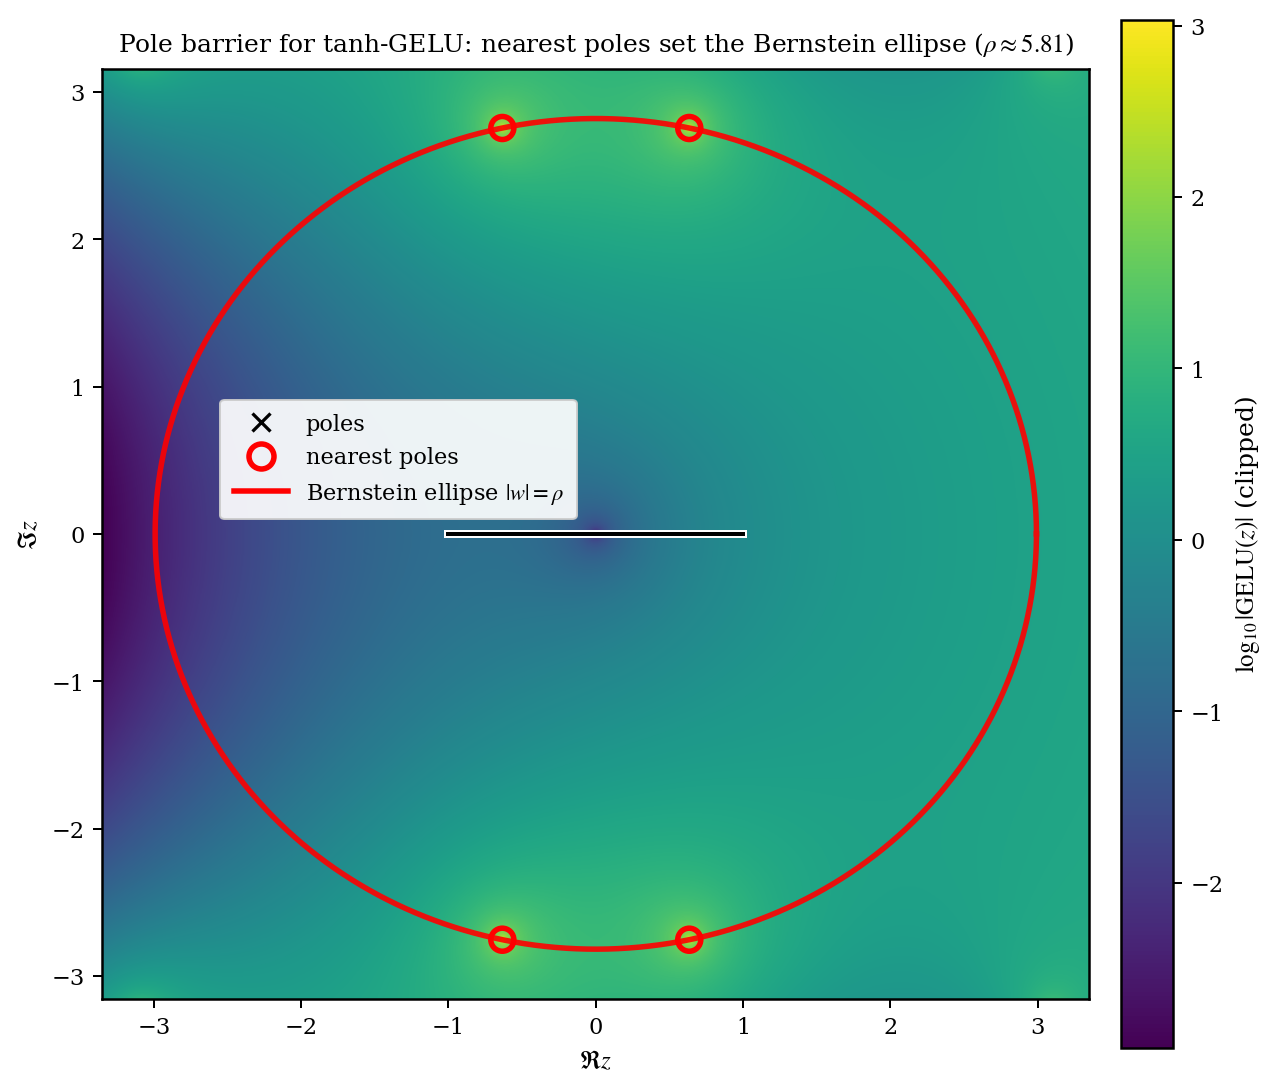

In [18]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -----------------------------
# tanh-GELU (common approximation)
# GELU(x) ≈ 0.5 x (1 + tanh( sqrt(2/pi) (x + 0.044715 x^3) ))
# Poles come from tanh poles: s*(a z + b z^3) = i(pi/2 + k pi)
# -----------------------------
A = np.sqrt(2.0 / np.pi)
B = A * 0.044715

SCALE_S = 1.0
K_MAX = 6

NX, NY = 900, 900
LOGABS_MIN, LOGABS_MAX = -6.0, 6.0

OUT_PNG = "gelu_pole_barrier_fixed.png"
OUT_PDF = "gelu_pole_barrier_fixed.pdf"


def gelu_complex(z, a=A, b=B, s=SCALE_S):
    return 0.5 * z * (1.0 + np.tanh(s * (a * z + b * z**3)))


def compute_poles(a=A, b=B, s=SCALE_S, k_max=K_MAX):
    poles = []
    for k in range(-k_max, k_max + 1):
        ck = (np.pi / 2.0 + k * np.pi) / s
        # b z^3 + a z - i ck = 0
        coeffs = np.array([b, 0.0, a, -1j * ck], dtype=complex)
        poles.extend(np.roots(coeffs))
    return np.array(poles, dtype=complex)


def ellipse_points_from_rho(rho, npts=1600):
    theta = np.linspace(0.0, 2.0 * np.pi, npts, endpoint=True)
    w = rho * np.exp(1j * theta)
    return 0.5 * (w + 1.0 / w)


def rho_from_point(z):
    """
    For E=[-1,1], the Joukowsky map z=(w+w^{-1})/2 sends |w|=rho to a Bernstein ellipse.
    Given z (outside E), solve w = z ± sqrt(z^2-1). One root has |w|>1.
    Define rho(z) := max(|w_+|, |w_-|). This is the *correct* ellipse parameter
    determined by the pole location (no assumption z=±i*zeta).
    """
    s = np.sqrt(z * z - 1.0 + 0j)
    w1 = z + s
    w2 = z - s
    return float(max(abs(w1), abs(w2)))


def filter_out_set(poles_arr, bad_set, tol=1e-9):
    keep = np.ones(poles_arr.shape[0], dtype=bool)
    for b in bad_set:
        keep &= (np.abs(poles_arr - b) > tol)
    return poles_arr[keep]


# ---- poles / nearest poles (correct Green-function sense) ----
poles = compute_poles()

# Compute rho for each pole, pick the smallest rho (closest barrier to [-1,1])
rho_vals = np.array([rho_from_point(z) for z in poles], dtype=float)
rho_min = float(np.min(rho_vals))

# All poles achieving the minimum rho (typically a symmetric quartet here)
REL_TOL = 5e-7
ABS_TOL = 5e-9
nearest_mask = (rho_vals <= rho_min * (1.0 + REL_TOL) + ABS_TOL)
nearest_poles = poles[nearest_mask]

# Correct barrier curve: Bernstein ellipse |w|=rho_min
ellipse = ellipse_points_from_rho(rho_min)

# Auto window from ellipse semiaxes:
# a = (rho + rho^{-1})/2, b = (rho - rho^{-1})/2
a_semi_major = 0.5 * (rho_min + 1.0 / rho_min)
b_semi_minor = 0.5 * (rho_min - 1.0 / rho_min)
X_MAX = 1.12 * a_semi_major
Y_MAX = 1.12 * b_semi_minor
X_MIN, Y_MIN = -X_MAX, -Y_MAX

# ---- heatmap ----
xs = np.linspace(X_MIN, X_MAX, NX)
ys = np.linspace(Y_MIN, Y_MAX, NY)
X, Y = np.meshgrid(xs, ys)
Z = X + 1j * Y

F = gelu_complex(Z)
logabs = np.log10(np.maximum(np.abs(F), 1e-300))
logabs = np.clip(logabs, LOGABS_MIN, LOGABS_MAX)

# Poles inside view
in_view = (
    (poles.real >= X_MIN) & (poles.real <= X_MAX) &
    (poles.imag >= Y_MIN) & (poles.imag <= Y_MAX)
)
poles_view = poles[in_view]

nearest_view = nearest_poles[
    (nearest_poles.real >= X_MIN) & (nearest_poles.real <= X_MAX) &
    (nearest_poles.imag >= Y_MIN) & (nearest_poles.imag <= Y_MAX)
]

# Remove nearest poles from generic scatter so circles stay clean
poles_view_wo_nearest = filter_out_set(poles_view, nearest_view, tol=1e-9)

# ---- plot ----
fig, ax = plt.subplots(figsize=(7.2, 6.6), dpi=180)

im = ax.imshow(
    logabs,
    extent=[X_MIN, X_MAX, Y_MIN, Y_MAX],
    origin="lower",
    aspect="equal",
    interpolation="bilinear",
)

# E=[-1,1]
ax.plot([-1, 1], [0, 0], linewidth=3.2, color="white", zorder=3)
ax.plot([-1, 1], [0, 0], linewidth=1.6, color="black", zorder=4)

# Other poles
ax.scatter(
    poles_view_wo_nearest.real, poles_view_wo_nearest.imag,
    s=28, marker="x", linewidths=1.3,
    color="black", zorder=5
)

# Nearest poles (draw ABOVE legend to avoid any “legend covers circles” issue)
ax.scatter(
    nearest_view.real, nearest_view.imag,
    s=85, marker="o", facecolors="none",
    edgecolors="red", linewidths=2.2, zorder=20
)

# Barrier ellipse
ax.plot(
    ellipse.real, ellipse.imag,
    color="red", linewidth=2.2, alpha=0.9, zorder=10
)

ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.set_xlabel(r"$\Re z$")
ax.set_ylabel(r"$\Im z$")
ax.set_title(
    rf"Pole barrier for tanh-GELU: nearest poles set the Bernstein ellipse ($\rho\approx {rho_min:.3g}$)"
)

cbar = fig.colorbar(im, ax=ax, fraction=0.048, pad=0.03)
cbar.set_label(r"$\log_{10}|{\rm GELU}(z)|$ (clipped)")

# ---- Legend: fixed INSIDE (not a corner), and forced BEHIND the data ----
handles = [
    Line2D([0], [0], marker="x", color="black", linestyle="None",
           markersize=7.5, markeredgewidth=1.3, label="poles"),
    Line2D([0], [0], marker="o", color="red", linestyle="None",
           markersize=10.0, markerfacecolor="none", markeredgewidth=2.2,
           label="nearest poles"),
    Line2D([0], [0], color="red", linewidth=2.2,
           label=rf"Bernstein ellipse $|w|=\rho$"),
]

# Pick a stable “inside but not corner” position:
# center-left-ish, slightly above midline so it doesn't sit on the [-1,1] segment.
leg = ax.legend(
    handles=handles,
    loc="center",
    bbox_to_anchor=(0.30, 0.58),   # INSIDE, not corner
    framealpha=0.92,
    fancybox=True,
    borderpad=0.6,
    handlelength=2.4,
    labelspacing=0.5
)

# Make sure legend does NOT cover circles: put legend behind everything.
leg.set_zorder(1)
leg.get_frame().set_linewidth(0.8)

fig.tight_layout()
fig.savefig(OUT_PNG, bbox_inches="tight")
fig.savefig(OUT_PDF, bbox_inches="tight")
print(f"Saved: {OUT_PNG}")
print(f"Saved: {OUT_PDF}")
